# Test dfmaker

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
from os import path
import sys
import uproot
from tqdm import tqdm
import tracemalloc
import time
# import line_profiler


# local imports
# from variable_configs import *

sys.path.append('/exp/sbnd/app/users/munjung/xsec/wienersvd/cafpyana')
from analysis_village.numucc1p0pi.selection_definitions import *
from analysis_village.numucc1p0pi.makedf.makedf import *
# from analysis_village.numucc1p0pi.makedf.makecov import *
from pyanalib.split_df_helpers import *
from pyanalib.stat_helpers import *
from makedf.constants import *
from makedf.geniesyst import regen_systematics_sbnd_multisigma, regen_systematics_sbnd_morph
from pyanalib.variable_calculator import get_cc1p0pi_tki
from analysis_village.unfolding.unfolding_inputs import *
from variable_configs import VariableConfig
from pyanalib.pandas_helpers import pad_column_name

plt.style.use("presentation.mplstyle")

# suppress warnings
import warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

ModuleNotFoundError: No module named 'variable_configs'

In [ ]:
def get_geniewgts(df, wgt_types=["bnb","genie"]):
    df.loc[:,'nuint_categ'] = get_int_category(df)
    df.loc[:,'genie_categ'] = get_genie_category(df)

    dict_univ_counts = {}
    for var_config in var_configs:
        for topo_mode in mode_list:
            this_df = df[df.nuint_categ == topo_mode]

            ## CV
            n_cv, bins = np.histogram(this_df[var_config.var_nu_col], bins=var_config.bins)
            cv_col_name = ("nuint_categ_"+str(topo_mode), 
                        "_".join([str(s) for s in var_config.var_nu_col if s]),
                        "cv",
                        "")
            dict_univ_counts[cv_col_name] = n_cv

            ## GENIE
            if "genie" in wgt_types:

                # multisim
                syst_name = "GENIE"
                n_syst_univ = 100

                n_univ = np.zeros((n_syst_univ, len(var_config.bin_centers)))
                for i in range(n_syst_univ):
                    weights = this_df[syst_name]["univ_{}".format(i)]
                    weights[np.isnan(weights)] = 1
                    n_univ[i, :] = np.histogram(this_df[var_config.var_nu_col], bins=var_config.bins, weights=weights)[0]
                    col_name = ("nuint_categ_"+str(topo_mode), 
                                "_".join([str(s) for s in var_config.var_nu_col if s]),
                                syst_name+"_multisim", 
                                "univ_{}".format(i))
                    dict_univ_counts[col_name] = n_univ[i, :]

                # multisigma
                n_syst_univ = 6
                for syst_name in regen_systematics_sbnd_multisigma:
                    n_univ = np.zeros((n_syst_univ, len(var_config.bin_centers)))
                    for i in range(n_syst_univ):
                        if (i < 3):
                            pm = "ms"
                        else:
                            pm = "ps"
                        sig = i%3 + 1
                        weights = this_df[syst_name][pm+str(sig)]
                        weights[np.isnan(weights)] = 1
                        n_univ[i, :] = np.histogram(this_df[var_config.var_nu_col], bins=var_config.bins, weights=weights)[0]
                        col_name = ("nuint_categ_"+str(topo_mode), 
                                    "_".join([str(s) for s in var_config.var_nu_col if s]),
                                    syst_name,
                                    "univ_{}".format(i))
                        dict_univ_counts[col_name] = n_univ[i, :]

                # morph
                n_syst_univ = 1
                for syst_name in regen_systematics_sbnd_morph:
                    n_univ = np.zeros((n_syst_univ, len(var_config.bin_centers)))
                    for i in range(n_syst_univ):
                        weights = this_df[syst_name]["morph"]
                        weights[np.isnan(weights)] = 1
                        n_univ[i, :] = np.histogram(this_df[var_config.var_nu_col], bins=var_config.bins, weights=weights)[0]
                        col_name = ("nuint_categ_"+str(topo_mode), 
                                    "_".join([str(s) for s in var_config.var_nu_col if s]),
                                    syst_name,
                                    "univ_{}".format(i))
                        dict_univ_counts[col_name] = n_univ[i, :]

            if "bnb" in wgt_types:

                ## Flux
                syst_name = "Flux"
                n_syst_univ = 500
                n_univ = np.zeros((n_syst_univ, len(var_config.bin_centers)))
                for i in range(n_syst_univ):
                    weights = this_df[syst_name]["univ_{}".format(i)]
                    weights[np.isnan(weights)] = 1
                    n_univ[i, :] = np.histogram(this_df[var_config.var_nu_col], bins=var_config.bins, weights=weights)[0]
                    col_name = ("nuint_categ_"+str(topo_mode), 
                                "_".join([str(s) for s in var_config.var_nu_col if s]),
                                syst_name, 
                                "univ_{}".format(i))
                    dict_univ_counts[col_name] = n_univ[i, :]


            # if "mcstat" in wgt_types:
            #     ## MCStat
            #     n_univ_mcstat = 500
            #     mc_evt_df, MCstat_univ_events = mcstat(mc_evt_df, mc_hdr_df, n_universes=n_univ_mcstat)

    df_univ_counts = pd.DataFrame(dict_univ_counts)
    if not isinstance(df_univ_counts.columns, pd.MultiIndex):
        df_univ_counts.columns = pd.MultiIndex.from_tuples(df_univ_counts.columns)

    return df_univ_counts

In [ ]:
# save_fig = True
save_fig_dir = "/exp/sbnd/data/users/munjung/plots/wiener_svd/1mu1p"

In [ ]:
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)

# load dataframes

In [43]:
## -- MC study
# mc_file = "/exp/sbnd/data/users/munjung/xsec/2025B/MC_test.df"
# mc_file = "/exp/sbnd/app/users/munjung/xsec/wienersvd/cafpyana/test.df"
mc_file = "/exp/sbnd/data/users/munjung/xsec/2025B/trash/MCP2025B_bnb_sel_half.df"
# mc_file = "/exp/sbnd/data/users/munjung/xsec/2025B/MCP2025B_bnb_cosmics_hadded_2prong.df"
mc_split_df = pd.read_hdf(mc_file, key="split")
mc_n_split = get_n_split(mc_file)
print("mc_n_split: %d" %(mc_n_split))
print_keys(mc_file)

mc_n_split: 3
Keys: ['/evt_0', '/evt_1', '/evt_2', '/hdr_0', '/hdr_1', '/hdr_2', '/mcnuwgtslim_0', '/mcnuwgtslim_1', '/mcnuwgtslim_2', '/split']


In [44]:
n_max_concat = 5

mc_keys2load = ['evt', 'hdr', 'mcnuwgtslim']
mc_dfs = load_dfs(mc_file, mc_keys2load, n_max_concat=n_max_concat)

mc_evt_df = mc_dfs['evt']
mc_hdr_df = mc_dfs['hdr']
mc_nu_df = mc_dfs['mcnuwgtslim']

In [45]:
# offbeam cosmics data
# data_keys2load = ['evt', 'hdr']
# # data_offbeam_file = '/exp/sbnd/data/users/munjung/xsec/2025B/data_offbeam.df'
# data_offbeam_file = "/exp/sbnd/data/users/munjung/xsec/2025B/data_offbeam_full.df"
# data_offbeam_dfs = load_dfs(data_offbeam_file, data_keys2load, n_max_concat=n_max_concat)
# data_offbeam_evt_df = data_offbeam_dfs['evt']
# data_offbeam_hdr_df = data_offbeam_dfs['hdr']
# data_offbeam_gates = data_offbeam_hdr_df[data_offbeam_hdr_df['first_in_subrun'] == 1]['noffbeambnb'].sum()
# print("intime cosmics data gates: {:.2e}".format(data_offbeam_gates))
# f = 0.08
# scale_offbeam_to_lightdata = (1-f)*data_gates/data_offbeam_gates
# print("goal scale: {:.2f}".format(scale_offbeam_to_lightdata))
# data_offbeam_evt_df["gates_weight"] = scale_offbeam_to_lightdata * np.ones(len(data_offbeam_evt_df))

In [46]:
from pyanalib.variable_calculator import get_cc1p0pi_tki

mudf = mc_evt_df.mu
pdf = mc_evt_df.p
P_mu_col = ("pfp", "trk", "rangeP", "p_muon" )
P_p_col = ("pfp", "trk", "rangeP", "p_proton" )
ret_tki = get_cc1p0pi_tki(mudf, pdf, P_mu_col, P_p_col)
mc_evt_df["del_Tp"] = ret_tki["del_Tp"]
mc_evt_df["del_p"] = ret_tki["del_p"]
mc_evt_df["del_alpha"] = ret_tki["del_alpha"]
mc_evt_df["del_phi"] = ret_tki["del_phi"]
mc_evt_df["del_alpha"] *= 180/np.pi
mc_evt_df["del_phi"] *= 180/np.pi

# truth
P_mu_col = ("pfp", "trk", "truth", "p" , "totp")
P_p_col = ("pfp", "trk", "truth", "p" , "totp")
ret_tki = get_cc1p0pi_tki(mudf, pdf, P_mu_col, P_p_col)
mc_evt_df["del_Tp_truth"] = ret_tki["del_Tp"]
mc_evt_df["del_p_truth"] = ret_tki["del_p"]
mc_evt_df["del_alpha_truth"] = ret_tki["del_alpha"]
mc_evt_df["del_phi_truth"] = ret_tki["del_phi"]
mc_evt_df["del_alpha_truth"] *= 180/np.pi
mc_evt_df["del_phi_truth"] *= 180/np.pi

# nu dfs
mudf = mc_nu_df.mu
pdf = mc_nu_df.p
P_mu_col = ("totp",)
P_p_col = ("totp",)
ret_tki = get_cc1p0pi_tki(mudf, pdf, P_mu_col, P_p_col)
mc_nu_df["del_Tp"] = ret_tki["del_Tp"]
mc_nu_df["del_p"] = ret_tki["del_p"]
mc_nu_df["del_alpha"] = ret_tki["del_alpha"]
mc_nu_df["del_phi"] = ret_tki["del_phi"]
mc_nu_df["del_alpha"] *= 180/np.pi
mc_nu_df["del_phi"] *= 180/np.pi

/exp/sbnd/app/users/munjung/xsec/wienersvd/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/exp/sbnd/app/users/munjung/xsec/wienersvd/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Make MCstat uncertainty universes

In [47]:
n_univ_mcstat = 500
mc_evt_df, MCstat_univ_events = mcstat(mc_evt_df, mc_hdr_df, n_universes=n_univ_mcstat)

## POT

In [48]:
## total pot
mc_tot_pot = mc_hdr_df['pot'].sum()
print("mc_tot_pot: %.3e" %(mc_tot_pot))

target_pot = 1e20
mc_pot_scale = target_pot / mc_tot_pot
print("mc_pot_scale: %.3e" %(mc_pot_scale))
mc_pot_scale = 1.

mc_evt_df["pot_weight"] = mc_pot_scale * np.ones(len(mc_evt_df))

mc_tot_pot: 1.504e+19
mc_pot_scale: 6.648e+00


## Constants

['flux_sbnd_numu;1', 'flux_sbnd_nue;1', 'flux_sbnd_anumu;1', 'flux_sbnd_anue;1']


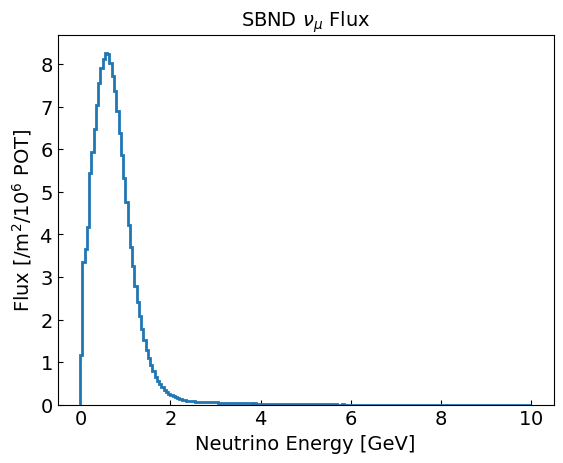

Integrated flux: 2.429e+11


In [49]:
# TODO: z-dependence?
# flux file, units: /m^2/10^6 POT 
# 50 MeV bins
fluxfile = "/exp/sbnd/data/users/munjung/flux/sbnd_original_flux.root"
flux = uproot.open(fluxfile)
print(flux.keys())

# numu flux
numu_flux = flux["flux_sbnd_numu"].to_numpy()
bin_edges = numu_flux[1]
flux_vals = numu_flux[0]

plt.hist(bin_edges[:-1], bins=bin_edges, weights=flux_vals, histtype="step", linewidth=2)
plt.xlabel("Neutrino Energy [GeV]")
plt.ylabel("Flux [/m$^{2}$/10$^{6}$ POT]")
plt.title("SBND $\\nu_\\mu$ Flux")

# if save_fig:
#     plt.savefig("{}/sbnd-flux.pdf".format(save_fig_dir))
plt.savefig("sbnd-flux.pdf", bbox_inches='tight')
plt.show()

# get integrated flux
integrated_flux = flux_vals.sum()
integrated_flux /= 1e4 # to cm2
INTEGRATED_FLUX = integrated_flux * mc_tot_pot / 1e6 # POT
print("Integrated flux: %.3e" % INTEGRATED_FLUX)

In [50]:
V_SBND = 380 * 380 * 440 # cm3, the active volume of the detector 
NTARGETS = RHO * V_SBND * N_A / M_AR
print("# of targets: ", NTARGETS)

# of targets:  1.3251484770937053e+30


In [51]:
# set to 1 for event rates
XSEC_UNIT = 1 / (INTEGRATED_FLUX * NTARGETS)

# XSEC_UNIT = 1
print("xsec unit: ", XSEC_UNIT)

xsec unit:  3.1066754821600304e-42


## Set up utils and selections according to target channel

In [52]:
# to make it work with the get_covariance function...

# Turn GENIE multisigma into multisims with 2 universes
for knob in regen_systematics_sbnd_multisigma:
    mc_evt_df[(knob, "univ_0", "", "", "", "", "", "")] = mc_evt_df[knob].ps1
    mc_evt_df[(knob, "univ_1", "", "", "", "", "", "")] = mc_evt_df[knob].ms1

# Turn GENIE unisim into multisims with 1 universe
for knob in regen_systematics_sbnd_morph:
    mc_evt_df[(knob, "univ_0", "", "", "", "", "", "")] = mc_evt_df[knob].morph

In [53]:
# classify events into categories
mc_evt_df.loc[:,'nuint_categ'] = get_int_category(mc_evt_df)
mc_nu_df.loc[:,'nuint_categ'] = get_int_category(mc_nu_df)

mc_evt_df.loc[:,'genie_categ'] = get_genie_category(mc_evt_df)
mc_nu_df.loc[:,'genie_categ'] = get_genie_category(mc_nu_df)

print(mc_evt_df.nuint_categ.value_counts())
print(mc_nu_df.nuint_categ.value_counts()) # won't have -1 because nudf is all nu events

nuint_categ
 1    2354
 0     153
 3      65
 2      62
 4      39
-1      14
 5       4
Name: count, dtype: int64
nuint_categ
0    202359
3     33612
4     25489
1     21845
2      8605
5      1532
Name: count, dtype: int64


## Choose Variable to Unfold

In [54]:
save_fig = False
# choose a variable to unfold, defined in variable_configs.py
var_config = VariableConfig.muon_momentum()
# var_config = VariableConfig.muon_direction()
# var_config = VariableConfig.proton_momentum()
# var_config = VariableConfig.proton_direction()
# var_config = VariableConfig.tki_del_Tp()
# var_config = VariableConfig.tki_del_alpha()
# var_config = VariableConfig.tki_del_phi()

## Make dfs for analysis

np.clip is for including underflow events into the first bin and overflow events into the last bin

In [55]:
# Total MC reco muon momentum: for fake data
eps = 1e-8
var_total_mc = mc_evt_df[var_config.var_evt_reco_col]
var_total_mc = np.clip(var_total_mc, var_config.bins[0], var_config.bins[-1] - eps)
weights_total_mc = mc_evt_df.loc[:, 'pot_weight']

# --- all events, selected ---
# mc_evt_df divided into topology modes for subtraction from data in future
# first item in list is the signal topology
mc_evt_df_divided = [mc_evt_df[mc_evt_df.nuint_categ == mode]for mode in mode_list]

# Reco variable distribution for each 'nuint_categ' for stack plot and subtraction from the fake data
var_per_nuint_categ_mc = [mc_evt_df[mc_evt_df.nuint_categ == mode][var_config.var_evt_reco_col]for mode in mode_list]
var_per_nuint_categ_mc = [s.clip(var_config.bins[0], var_config.bins[-1] - eps) for s in var_per_nuint_categ_mc]
weights_per_categ = [mc_evt_df.loc[mc_evt_df.nuint_categ == mode, 'pot_weight'] for mode in mode_list]

# Reco variable distribution for each genie mode
var_per_genie_mode_mc = [mc_evt_df[mc_evt_df.genie_categ == mode][var_config.var_evt_reco_col]for mode in genie_mode_list]
var_per_genie_mode_mc = [s.clip(var_config.bins[0], var_config.bins[-1] - eps) for s in var_per_genie_mode_mc]
weights_per_genie_mode = [mc_evt_df.loc[mc_evt_df.genie_categ == mode, 'pot_weight'] for mode in genie_mode_list]


# --- signal events ---
# selected, for response matrix
# Signal event's reco muon momentum after the event selection
var_signal_sel_reco = mc_evt_df[mc_evt_df.nuint_categ == 1][var_config.var_evt_reco_col]
var_signal_sel_reco = np.clip(var_signal_sel_reco, var_config.bins[0], var_config.bins[-1] - eps)
weight_signal = mc_evt_df.loc[mc_evt_df.nuint_categ == 1, 'pot_weight']

# Signal event's true muon momentum after the event selection
var_signal_sel_truth = mc_evt_df[mc_evt_df.nuint_categ == 1][var_config.var_evt_truth_col]
var_signal_sel_truth = np.clip(var_signal_sel_truth, var_config.bins[0], var_config.bins[-1] - eps)
weight_true_signal = mc_evt_df.loc[mc_evt_df.nuint_categ == 1, 'pot_weight']

# total generated, for efficiency vector
# Signal event's true muon momentum without event selection
var_truth_signal = mc_nu_df[mc_nu_df.nuint_categ == 1][var_config.var_nu_col]
var_truth_signal = np.clip(var_truth_signal, var_config.bins[0], var_config.bins[-1] - eps)
weight_truth_signal = np.full_like(var_truth_signal, mc_pot_scale, dtype=float)

## Response Matrix

Draw true (before event selection) and reco (after event selection) muon momentum distributions of signal events.
Print entries for double check.

[3289. 1849. 1851. 1900. 1675. 1651. 1558. 1354. 1252. 1197.  948.  875.
 1362. 1084.]
[234. 338. 304. 292. 251. 213. 157. 146. 121.  87.  61.  49.  67.  34.]
[231. 325. 288. 310. 233. 222. 155. 144. 117.  94.  57.  54.  77.  47.]


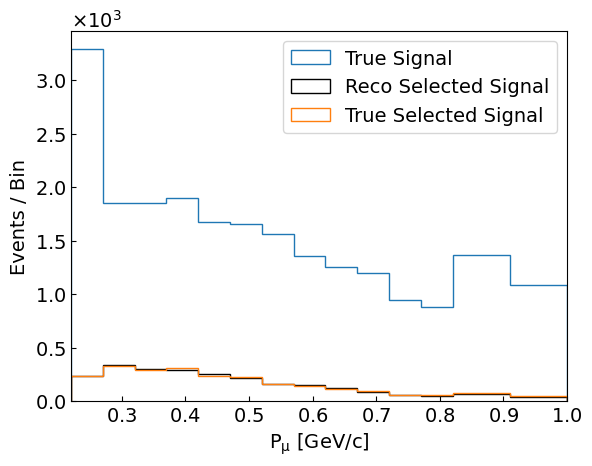

In [56]:
nevts_signal_truth, _, _ = plt.hist(var_truth_signal, bins=var_config.bins, weights=weight_truth_signal, histtype="step", label="True Signal")
nevts_signal_sel_reco, _, _ = plt.hist(var_signal_sel_reco, bins=var_config.bins, weights=weight_signal, histtype="step", label="Reco Selected Signal", color="k")
nevts_signal_sel_truth, _, _ = plt.hist(var_signal_sel_truth, bins=var_config.bins, weights=weight_signal, histtype="step", label="True Selected Signal")
print(nevts_signal_truth)
print(nevts_signal_sel_reco)
print(nevts_signal_sel_truth)
plt.legend()
plt.ylabel("Events / Bin")
plt.xlim(var_config.bins[0], var_config.bins[-1])
plt.xlabel(var_config.var_labels[0])
if save_fig:
    plt.savefig("{}/{}-sel_event_rates.pdf".format(save_fig_dir, var_config.var_save_name), bbox_inches='tight')
plt.show()

[[217.  13.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  9. 290.  26.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  1.  16. 253.  18.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.  23. 257.  30.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   1.  15. 195.  20.   2.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   1.  23. 181.  17.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   1.  12. 119.  22.   1.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   1.   0.  18. 108.  17.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   1.  16.  90.  10.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.  13.  68.  13.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   8.  42.   7.   0.   0.]
 [  1.   0.   0.   0.   1.   0.   0.   0.   0.   0.   6.  31.  15.   0.]
 [  5.   3.   0.   0.   0.   0.   0.   0.   0.   1.   0.  11.  48.   9.]
 [  1.  16.   1.   0.   0.   0.   0.   0.   0.   0.

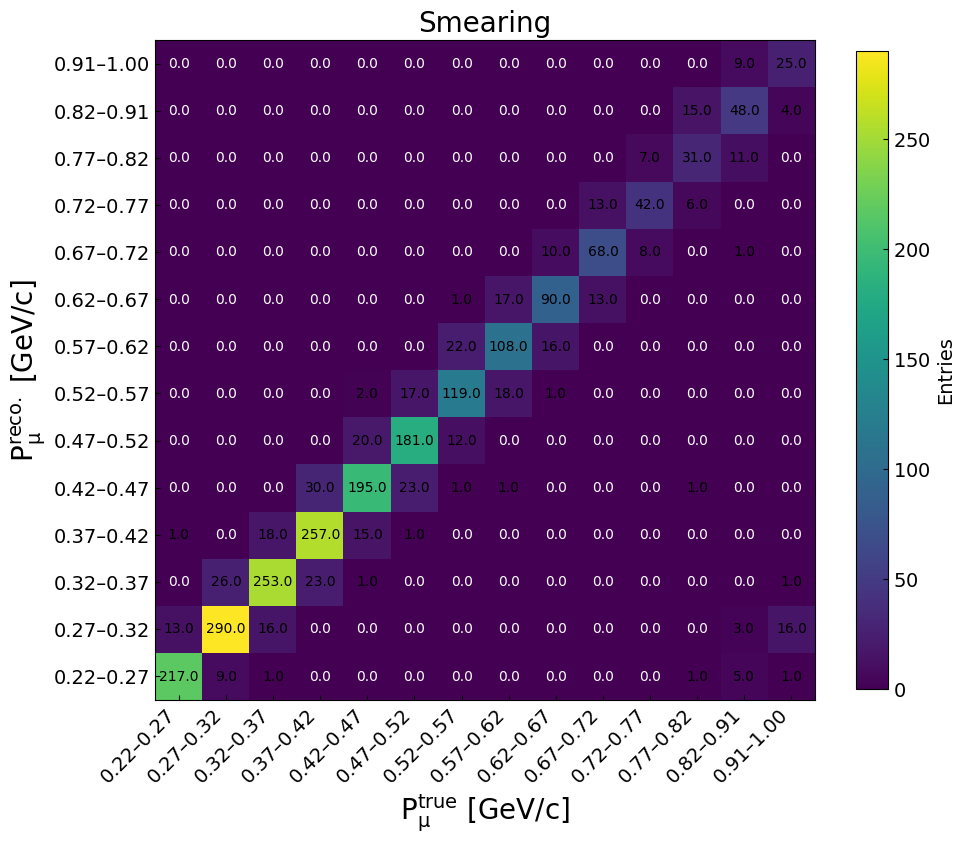

eff
[0.07023411 0.17577069 0.15559157 0.16315789 0.13910448 0.13446396
 0.09948652 0.10635155 0.09345048 0.07852966 0.06012658 0.06171429
 0.05653451 0.04335793]


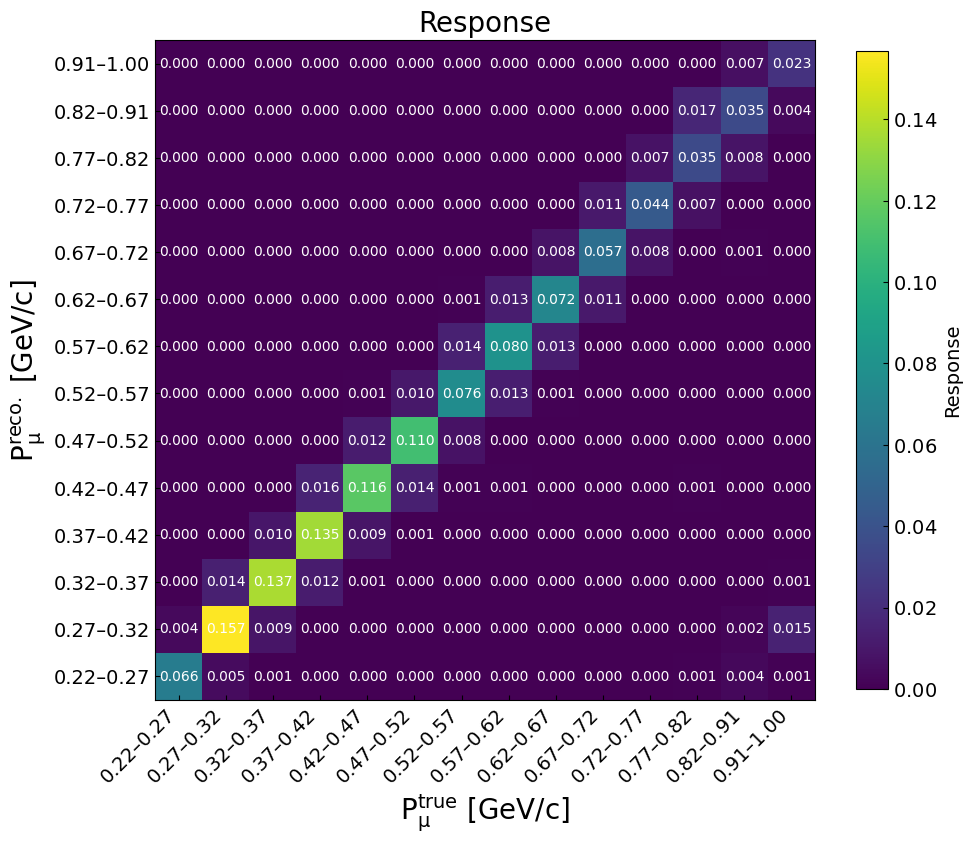

In [57]:
bins_2d = var_config.bins# = [np.array([0.2, 2]), np.array([0.2, 2])] # commented out lines for 1 bin MC closure test

save_fig_name = "{}/{}-reco_vs_true".format(save_fig_dir, var_config.var_save_name)
reco_vs_true = get_smear_matrix(var_signal_sel_truth, var_signal_sel_reco, bins_2d, var_labels=var_config.var_labels,
                                save_fig=save_fig, save_fig_name=save_fig_name)
eff = get_eff(reco_vs_true, nevts_signal_truth)
print("eff")
print(eff)

save_fig_name = "{}/{}-response_matrix".format(save_fig_dir, var_config.var_save_name)
Response = get_response_matrix(reco_vs_true, eff, var_config.bins, var_labels=var_config.var_labels,
                               save_fig=save_fig, save_fig_name=save_fig_name)

## Covariance

In [58]:
def get_covariance(cov_type, syst_name, n_univ, 
                   nevts_signal_sel_reco, var_signal_sel_truth, var_signal_sel_reco, bins, 
                   plot_labels, show_fig=True, save_fig=False, save_fig_name=None):

    if cov_type == "xsec":
        scale_factor = XSEC_UNIT
        print("generating covariance for xsec, using scale factor: {}".format(scale_factor))

    elif cov_type == "event":
        print("generating covariance for event rate")
        scale_factor = 1

    else:
        raise ValueError("Invalid cov_type: {}".format(cov_type))

    
    signal_cv = nevts_signal_sel_reco * scale_factor # = Response @ true_signal

    Covariance_Frac = np.zeros((len(signal_cv), len(signal_cv)))
    Covariance = np.zeros((len(signal_cv), len(signal_cv)))

    # init figure to plot event rates
    fig, ax = plt.subplots()

    univ_events = []
    for uidx in range(n_univ):
        univ_col_evt = (syst_name, "univ_{}".format(uidx), "", "", "", "", "", "")
        univ_col_mc = (syst_name, "univ_{}".format(uidx), "")

        # ---- uncertainty on the signal rate ----
        # GENIE syst need special treatment
        # we don't want uncertainty on the xsec
        # only consider its effect on the response matrix
        if syst_name == "GENIE" and cov_type == "xsec":
            true_signal_univ, _ = np.histogram(var_truth_signal, bins=var_config.bins, 
                                            weights=weight_truth_signal*mc_nu_df[mc_nu_df.nuint_categ == 1][univ_col_mc])
            
            # new response matrix for univ
            reco_vs_true = get_smear_matrix(var_signal_sel_truth, var_signal_sel_reco, var_config.bins, 
                                            weights=mc_evt_df[mc_evt_df.nuint_categ == 1][univ_col_evt], plot=False)

            eff = get_eff(reco_vs_true, true_signal_univ) 

            Response_univ = get_response_matrix(reco_vs_true, eff, bins, plot=False)
            signal_univ = Response_univ @ nevts_signal_truth # note that we multiply the CV signal rate!

        # for other systs, we just take the univ signal event rate
        else:
            signal_univ, _ = np.histogram(var_signal_sel_reco, bins=var_config.bins, 
                                             weights=mc_evt_df[mc_evt_df.nuint_categ == 1][univ_col_evt])

        signal_univ = np.array(signal_univ) * scale_factor

        # ---- uncertainty on the background rate ----
        # loop over background categories
        # + univ background - cv background
        # note: cv background subtraction cancels out with the cv background subtraction for the cv event rate. 
        #       doing it anyways for the plot of universes on background subtracted event rate.
        for this_mc_evt_df in mc_evt_df_divided[1:]:
            weights = this_mc_evt_df[univ_col_evt].copy()
            weights[np.isnan(weights)] = 1 ## IMPORTANT: make nan weights to 1. to ignore them
            this_var = this_mc_evt_df[var_config.var_evt_reco_col]
            this_var = np.clip(this_var, var_config.bins[0], var_config.bins[-1] - eps)
            background_univ, _ = np.histogram(this_var, bins=var_config.bins, weights=weights)
            background_cv, _ = np.histogram(this_var, bins=var_config.bins)
            background_univ = np.array(background_univ) * scale_factor
            background_cv = np.array(background_cv) * scale_factor
            signal_univ += background_univ - background_cv


        univ_events.append(signal_univ)
        plt.hist(var_config.bin_centers, bins=var_config.bins, weights=signal_univ, histtype="step", color="steelblue", linewidth=1)

        # ---- covariance calculation for this universe ----
        # I'm looping & calculating with the CV value for clarity, 
        # but techincally np.cov should also be fine under the assumption of gaussian universes that we're using
        for i in range(len(signal_univ)):
            for j in range(len(signal_univ)):
                nom_i = signal_cv[i] 
                nom_j = signal_cv[j] 

                univ_i = signal_univ[i] 
                univ_j = signal_univ[j] 

                cov_entry = (univ_i - nom_i) * (univ_j - nom_j)
                frac_cov_entry = ((univ_i - nom_i) / nom_i) * ( (univ_j - nom_j) / nom_j)

                # TODO: this clipping exists in the uboone code, but I'm not sure why..?
                # if cov_entry > 0:
                #     this_cov = max( cov_entry, eps * scale_factor)
                # else:
                #     this_cov = min( cov_entry, eps * scale_factor)

                # if frac_cov_entry > 0:
                #     this_frac_cov = max( frac_cov_entry, eps * scale_factor)
                # else:
                #     this_frac_cov = min( frac_cov_entry, eps * scale_factor)

                Covariance[i, j] += cov_entry
                Covariance_Frac[i, j] += frac_cov_entry

    plt.hist(var_config.bin_centers, bins=var_config.bins, weights=signal_cv, histtype="step", color="black")

    plt.xlim(var_config.bins[0], var_config.bins[-1])
    plt.xlabel(plot_labels[0])
    plt.ylabel(plot_labels[1])
    plt.title(syst_name)

    # legend from dummies
    plt.hist([], bins=var_config.bins, histtype="step", color="black", label="Central Value")
    plt.hist([], bins=var_config.bins, histtype="step", color="steelblue", label="Universe Value")
    plt.legend()

    Covariance = Covariance / n_univ
    Covariance_Frac = Covariance_Frac / n_univ
    Correlation = np.zeros_like(Covariance)
    for i in range(len(signal_cv)):
        for j in range(len(signal_cv)):
            Correlation[i, j] = Covariance[i, j] / (np.sqrt(Covariance[i, i]) * np.sqrt(Covariance[j, j]))

    if save_fig:
        plt.savefig("{}.png".format(save_fig_name), bbox_inches='tight', dpi=300)

    if show_fig:
        plt.show()

    return {"Covariance_Frac": Covariance_Frac, 
            "Covariance": Covariance,
            "Correlation": Correlation,
            "cv_events": signal_cv,
            "univ_events": univ_events,
            }

In [59]:
# pretty heatmap plotter

unif_bin = np.linspace(0., float(len(var_config.bins) - 1), len(var_config.bins))
extent = [unif_bin[0], unif_bin[-1], unif_bin[0], unif_bin[-1]]

x_edges = np.array(var_config.bins)
y_edges = np.array(var_config.bins)
x_tick_positions = (unif_bin[:-1] + unif_bin[1:]) / 2
y_tick_positions = (unif_bin[:-1] + unif_bin[1:]) / 2

x_labels = bin_range_labels(x_edges)
y_labels = bin_range_labels(y_edges)

def plot_heatmap(matrix, title, plot_labels=var_config.var_labels, save_fig=False, save_fig_name=None):
    fig, ax = plt.subplots(figsize=(12, 12))
    plt.imshow(matrix, extent=extent, origin="lower")
    plt.colorbar(shrink=0.7)
    plt.xticks(x_tick_positions, x_labels, rotation=45, ha="right")
    plt.yticks(y_tick_positions, y_labels)
    plt.xlabel(plot_labels[0])
    plt.ylabel(plot_labels[1])
    for i in range(matrix.shape[0]):      # rows (y)
        for j in range(matrix.shape[1]):  # columns (x)
            value = matrix[i, j]
            if not np.isnan(value):  # skip NaNs
                plt.text(
                    j + 0.5, i + 0.5,
                    f"{value:.2f}",
                    ha="center", va="center",   
                    color=get_text_color(value),
                    fontsize=10
                )
    plt.title(title)
    if save_fig:
        plt.savefig("{}.png".format(save_fig_name), bbox_inches='tight', dpi=300)
    plt.show();

## multisigma as unisims

In [60]:
save_fig = True
save_fig_dir

'/exp/sbnd/data/users/munjung/plots/wiener_svd/1mu1p'

In [62]:
cov_type = "event"

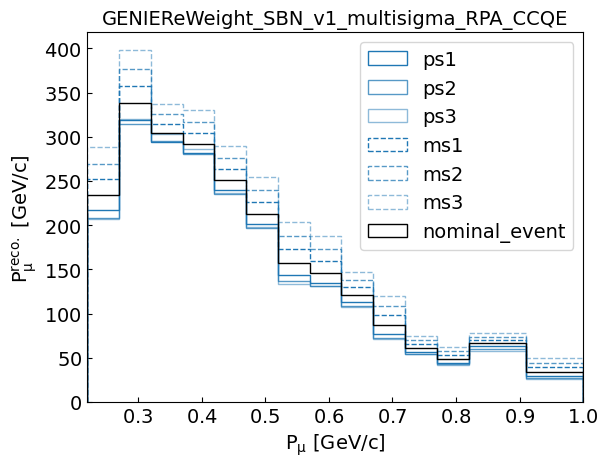

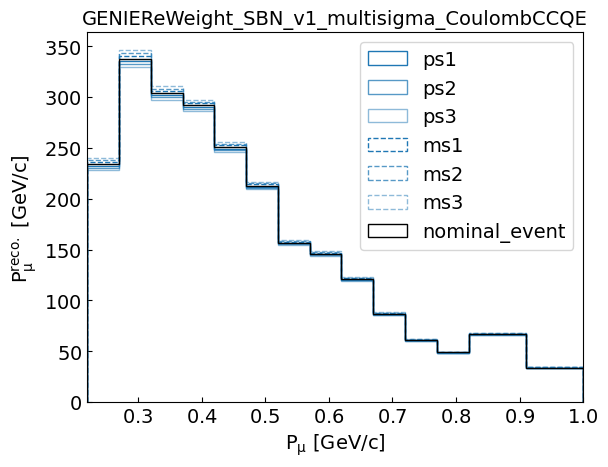

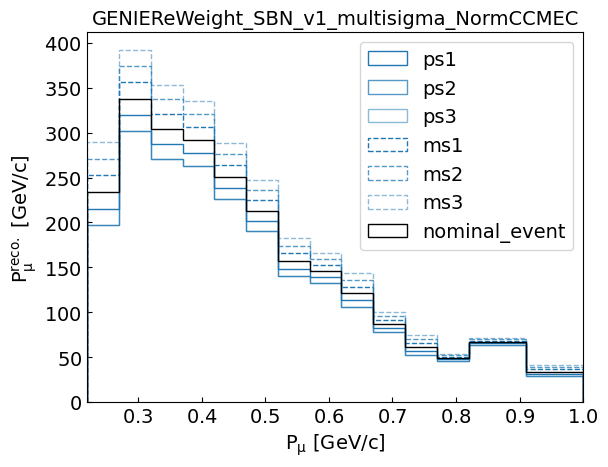

In [63]:
for knob in regen_systematics_sbnd_multisigma[:3]:
    plt.hist(var_signal_sel_reco, bins=var_config.bins, weights=mc_evt_df[mc_evt_df.nuint_categ == 1][knob].ps1, histtype="step", 
            color="C0", label="ps1")
    plt.hist(var_signal_sel_reco, bins=var_config.bins, weights=mc_evt_df[mc_evt_df.nuint_categ == 1][knob].ps2, histtype="step", 
            color="C0", label="ps2", alpha=0.75)
    plt.hist(var_signal_sel_reco, bins=var_config.bins, weights=mc_evt_df[mc_evt_df.nuint_categ == 1][knob].ps3, histtype="step", 
            color="C0", label="ps3", alpha=0.5)
    plt.hist(var_signal_sel_reco, bins=var_config.bins, weights=mc_evt_df[mc_evt_df.nuint_categ == 1][knob].ms1, histtype="step", 
            color="C0", label="ms1", linestyle="--")
    plt.hist(var_signal_sel_reco, bins=var_config.bins, weights=mc_evt_df[mc_evt_df.nuint_categ == 1][knob].ms2, histtype="step", 
            color="C0", label="ms2", linestyle="--", alpha=0.75)
    plt.hist(var_signal_sel_reco, bins=var_config.bins, weights=mc_evt_df[mc_evt_df.nuint_categ == 1][knob].ms3, histtype="step", 
            color="C0", label="ms3", linestyle="--", alpha=0.5)

    # TODO: is there any purpose of using cv? seems redundant...
    # plt.hist(var_signal_sel_reco, bins=var_config.bins, histtype="step", color="black", label="nominal_event")
    plt.hist(var_signal_sel_reco, bins=var_config.bins, weights=mc_evt_df[mc_evt_df.nuint_categ == 1][knob].cv, histtype="step", color="black", label="nominal_event")

    plt.xlim(var_config.bins[0], var_config.bins[-1])
    plt.xlabel(var_config.var_labels[0])
    plt.ylabel(var_config.var_labels[1])
    plt.title(knob)
    plt.legend()

    save_fig_name = "{}/{}-{}-geniemultisigma_univ_{}_rates".format(save_fig_dir, var_config.var_save_name, knob, cov_type)
    if save_fig:
        plt.savefig("{}.png".format(save_fig_name), bbox_inches='tight', dpi=300)

    plt.show()

In [65]:
regen_systematics_sbnd_multisigma

['GENIEReWeight_SBN_v1_multisigma_RPA_CCQE',
 'GENIEReWeight_SBN_v1_multisigma_CoulombCCQE',
 'GENIEReWeight_SBN_v1_multisigma_NormCCMEC',
 'GENIEReWeight_SBN_v1_multisigma_NormNCMEC',
 'GENIEReWeight_SBN_v1_multisigma_RDecBR1gamma',
 'GENIEReWeight_SBN_v1_multisigma_RDecBR1eta',
 'GENIEReWeight_SBN_v1_multisigma_NonRESBGvpCC1pi',
 'GENIEReWeight_SBN_v1_multisigma_NonRESBGvpCC2pi',
 'GENIEReWeight_SBN_v1_multisigma_NonRESBGvpNC1pi',
 'GENIEReWeight_SBN_v1_multisigma_NonRESBGvpNC2pi',
 'GENIEReWeight_SBN_v1_multisigma_NonRESBGvnCC1pi',
 'GENIEReWeight_SBN_v1_multisigma_NonRESBGvnCC2pi',
 'GENIEReWeight_SBN_v1_multisigma_NonRESBGvnNC1pi',
 'GENIEReWeight_SBN_v1_multisigma_NonRESBGvnNC2pi',
 'GENIEReWeight_SBN_v1_multisigma_NonRESBGvbarpCC1pi',
 'GENIEReWeight_SBN_v1_multisigma_NonRESBGvbarpCC2pi',
 'GENIEReWeight_SBN_v1_multisigma_NonRESBGvbarpNC1pi',
 'GENIEReWeight_SBN_v1_multisigma_NonRESBGvbarpNC2pi',
 'GENIEReWeight_SBN_v1_multisigma_NonRESBGvbarnCC1pi',
 'GENIEReWeight_SBN_v1_multi

generating covariance for event rate


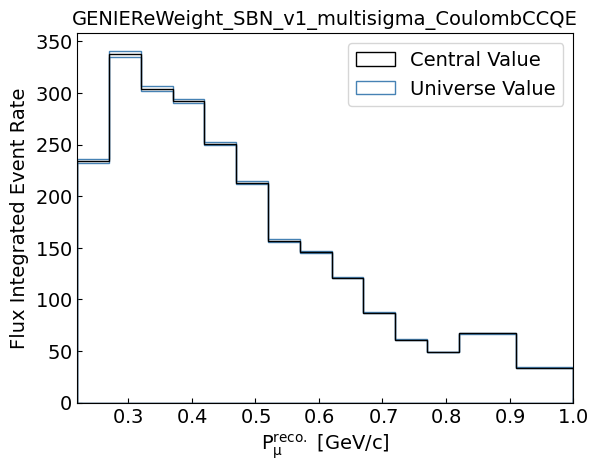

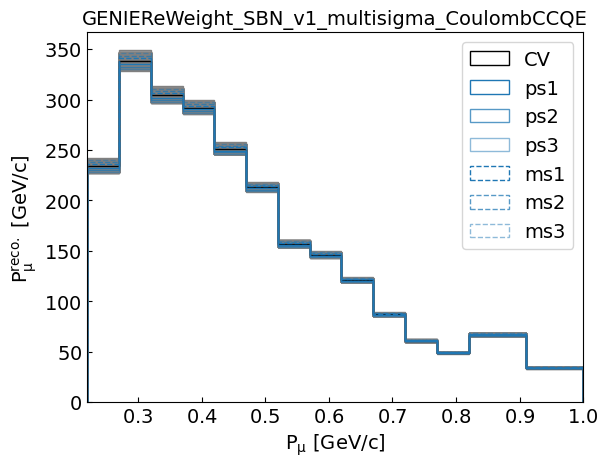

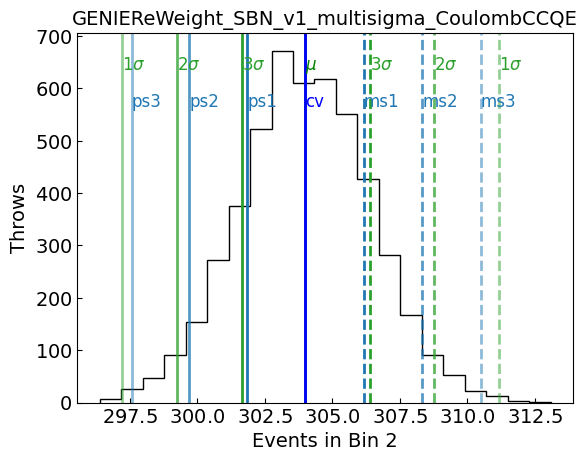

In [67]:
# ---- justification for the unisim treatment
# throw multivariate normal distribution to the bin center using 1 sigma,
# show that the 2 and 3 sigma are close to the 2 and 3 sigmas of the distribution, per bin

# test one knob 
knob = regen_systematics_sbnd_multisigma[1]
labels = [var_config.var_labels[1], "Flux Integrated Event Rate"]
save_fig_name = None
ret_geniemultisigma = get_covariance(cov_type, knob, 2, 
                          nevts_signal_sel_reco, var_signal_sel_truth, var_signal_sel_reco, var_config.bins, 
                          labels, save_fig=save_fig, save_fig_name=save_fig_name)

# plot event rate variations from thrown universes vs. multisigma
n_cv, _ = np.histogram(var_signal_sel_reco, bins=var_config.bins, weights=mc_evt_df[mc_evt_df.nuint_categ == 1][knob].cv)
universes_from_1sigma = np.random.multivariate_normal(n_cv, ret_geniemultisigma["Covariance"], size=5000)
for i in range(len(universes_from_1sigma)):
    plt.hist(var_config.bin_centers, bins=var_config.bins, weights=universes_from_1sigma[i], histtype="step", color="gray")

n_cv , _, _ = plt.hist(var_config.bin_centers, bins=var_config.bins, weights=n_cv, histtype="step", color="black", label="CV")
n_ps1, _, _ = plt.hist(var_signal_sel_reco, bins=var_config.bins, weights=mc_evt_df[mc_evt_df.nuint_categ == 1][knob].ps1, histtype="step", 
        color="C0", label="ps1")
n_ps2, _, _ = plt.hist(var_signal_sel_reco, bins=var_config.bins, weights=mc_evt_df[mc_evt_df.nuint_categ == 1][knob].ps2, histtype="step", 
        color="C0", label="ps2", alpha=0.75)
n_ps3, _, _ = plt.hist(var_signal_sel_reco, bins=var_config.bins, weights=mc_evt_df[mc_evt_df.nuint_categ == 1][knob].ps3, histtype="step", 
        color="C0", label="ps3", alpha=0.5)
n_ms1, _, _ = plt.hist(var_signal_sel_reco, bins=var_config.bins, weights=mc_evt_df[mc_evt_df.nuint_categ == 1][knob].ms1, histtype="step", 
        color="C0", label="ms1", linestyle="--")
n_ms2, _, _ = plt.hist(var_signal_sel_reco, bins=var_config.bins, weights=mc_evt_df[mc_evt_df.nuint_categ == 1][knob].ms2, histtype="step", 
        color="C0", label="ms2", linestyle="--", alpha=0.75)
n_ms3, _, _ = plt.hist(var_signal_sel_reco, bins=var_config.bins, weights=mc_evt_df[mc_evt_df.nuint_categ == 1][knob].ms3, histtype="step", 
        color="C0", label="ms3", linestyle="--", alpha=0.5)

plt.xlim(var_config.bins[0], var_config.bins[-1])
plt.xlabel(var_config.var_labels[0])
plt.ylabel(var_config.var_labels[1])
plt.title(knob)
plt.legend()
plt.show()

# look at the distributinon of weights in one bin
bin_idx = 2
this_wgts = universes_from_1sigma[:, bin_idx]
plt.hist(this_wgts, bins=21, histtype="step", color="black", label="weights from CAF ps1/ms1")

# sig levels from thrown universes
labels = ["3$\\sigma$", "2$\\sigma$", "1$\\sigma$"]
wgts_sig = np.percentile(this_wgts, np.array([(1-0.997)/2., (1-0.95)/2., (1-0.68)/2.,
                                      0.5+(0.68)/2., 0.5+(0.95)/2., 0.5+(0.997)/2.])*100)
wgts_cv = np.percentile(this_wgts, 50)
plt.axvline(wgts_cv, color="green", label="CV from weights")
plt.text(wgts_cv, plt.ylim()[1]*0.9, "$\\mu$", color="green", fontsize=12)
for sidx, s in enumerate(wgts_sig):
    if sidx <= 2:
        linestyle = "-"
        plt.axvline(s, color="C2", linestyle=linestyle, alpha=0.5+0.25*(sidx%3))
        plt.text(s, plt.ylim()[1]*0.9, labels[::-1][sidx%3], color="C2", fontsize=12)
    else:
        linestyle = "--"
        plt.axvline(s, color="C2", linestyle=linestyle, alpha=1-0.25*(sidx%3))
        plt.text(s, plt.ylim()[1]*0.9, labels[sidx%3], color="C2", fontsize=12)

# sig levels from cafs
plt.axvline(n_cv[bin_idx], color="blue")
plt.text(n_cv[bin_idx], plt.ylim()[1]*0.8, "cv", color="blue", fontsize=12)
plt.axvline(n_ps1[bin_idx], color="C0")
plt.text(n_ps1[bin_idx], plt.ylim()[1]*0.8, "ps1", color="C0", fontsize=12)
plt.axvline(n_ps2[bin_idx], color="C0", alpha=0.75)
plt.text(n_ps2[bin_idx], plt.ylim()[1]*0.8, "ps2", color="C0", fontsize=12)
plt.axvline(n_ps3[bin_idx], color="C0", alpha=0.5)
plt.text(n_ps3[bin_idx], plt.ylim()[1]*0.8, "ps3", color="C0", fontsize=12)
plt.axvline(n_ms1[bin_idx], color="C0", linestyle="--")
plt.text(n_ms1[bin_idx], plt.ylim()[1]*0.8, "ms1", color="C0", fontsize=12)
plt.axvline(n_ms2[bin_idx], color="C0", linestyle="--", alpha=0.75)
plt.text(n_ms2[bin_idx], plt.ylim()[1]*0.8, "ms2", color="C0", fontsize=12)
plt.axvline(n_ms3[bin_idx], color="C0", linestyle="--", alpha=0.5)
plt.text(n_ms3[bin_idx], plt.ylim()[1]*0.8, "ms3", color="C0", fontsize=12)
# plt.xlabel(var_config.var_labels[0] + ", Bin " + str(bin_idx))
plt.xlabel("Events in Bin " + str(bin_idx))
plt.ylabel("Throws")

plt.title(knob)
save_fig_name = "{}/{}-{}-Bin{}-multisigma_justification.pdf".format(save_fig_dir, var_config.var_save_name, knob, bin_idx)
if save_fig:
    plt.savefig(save_fig_name, bbox_inches='tight')
plt.show()

## universes from unisims

### Use the one universe

generating covariance for event rate


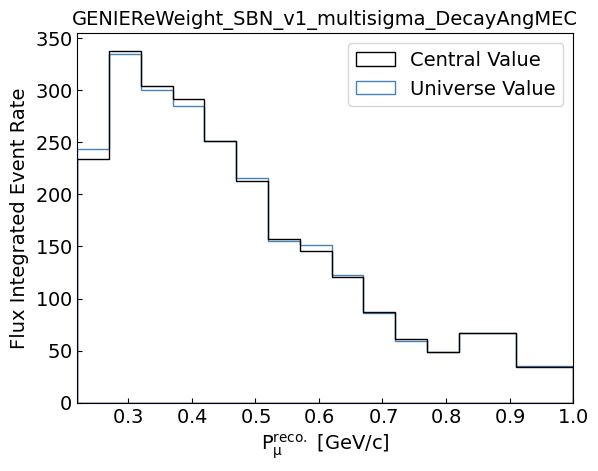

In [118]:
n_univ_genie_morph = 1

cov_type = "event"
GENIEmorph_Frac_Covariance_event = np.zeros((len(var_config.bins)-1, len(var_config.bins)-1))
plot_labels = [var_config.var_labels[1], "Flux Integrated Event Rate"]
# for kidx, knob in enumerate(regen_systematics_sbnd_morph[:3]):
knob = regen_systematics_sbnd_morph[1]
syst_name = knob
save_fig_name = "{}/{}-{}-geniemorph_univ_{}_rates".format(save_fig_dir, var_config.var_save_name, syst_name, cov_type)
ret_geniemorph = get_covariance(cov_type, syst_name, n_univ_genie_morph, 
                        nevts_signal_sel_reco, var_signal_sel_truth, var_signal_sel_reco, var_config.bins, 
                        plot_labels, save_fig=save_fig, save_fig_name=save_fig_name)
GENIEmorph_Frac_Covariance_event = GENIEmorph_Frac_Covariance_event + ret_geniemorph["Covariance_Frac"]


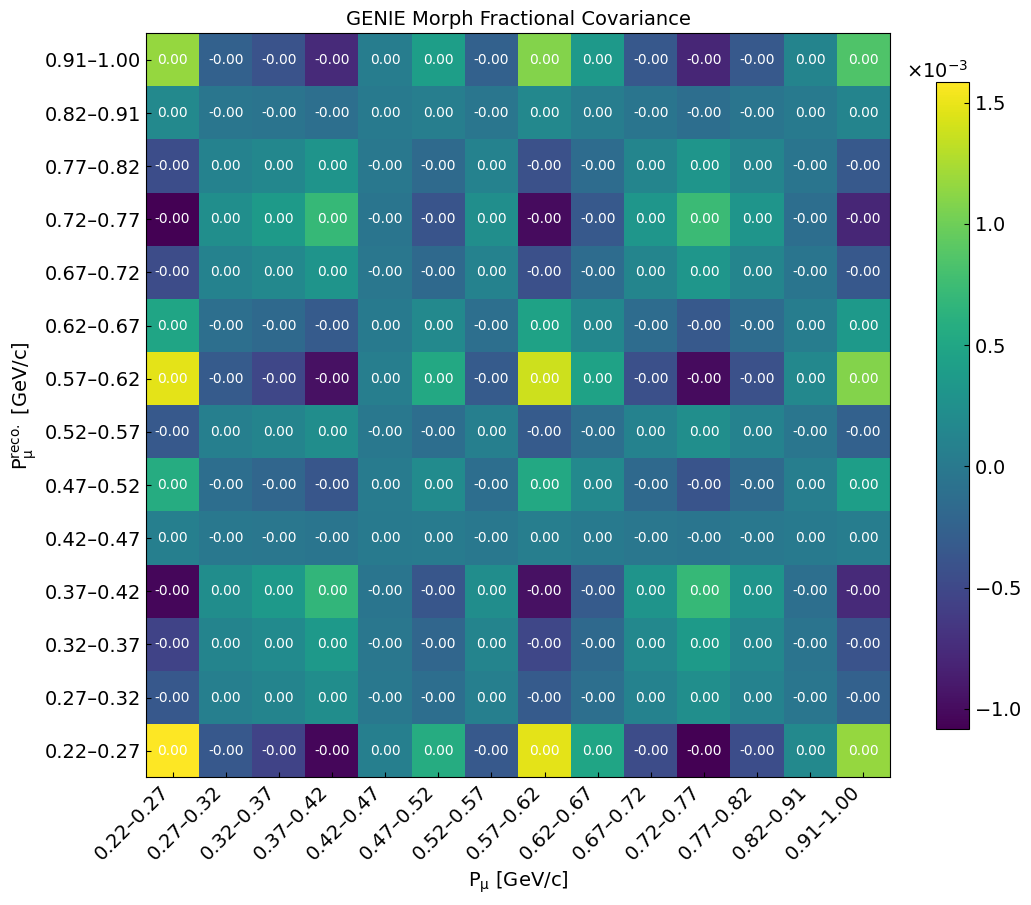

In [119]:
save_fig_name = "{}/{}-geniemorph_covariance_frac".format(save_fig_dir, var_config.var_save_name)
plot_heatmap(GENIEmorph_Frac_Covariance_event, "GENIE Morph Fractional Covariance",
             save_fig=save_fig, save_fig_name=save_fig_name)

In [120]:
mc_evt_df[knob]
for i in range(250):
    random_seed = hash(knob+str(i)) % (2**32)
    np.random.seed(random_seed)
    random_wgt = np.random.normal(0, 1)
    wgt = 1 + (mc_evt_df[knob].morph - 1) * np.abs(random_wgt)
    mc_evt_df[(knob, "univ_{}".format(i), "", "", "", "", "", "")] = wgt

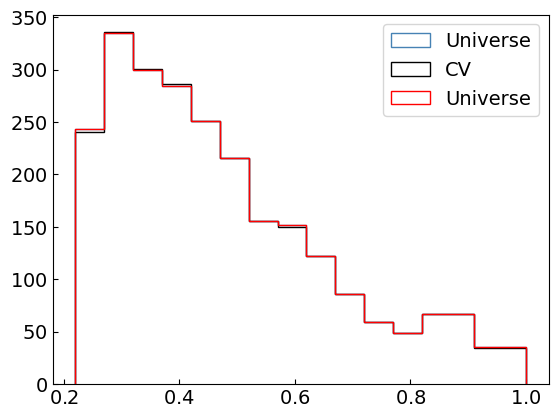

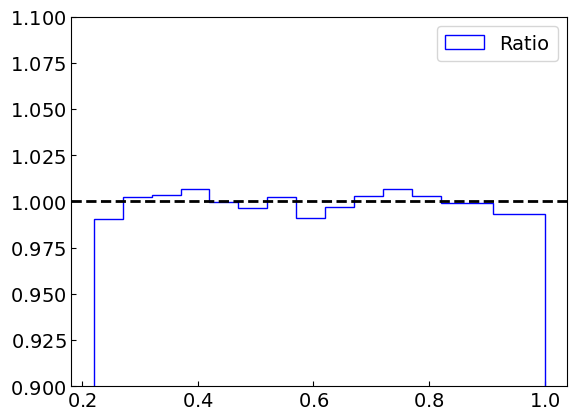

In [121]:
# Get the mean of all universes for this knob
df = mc_evt_df[mc_evt_df.nuint_categ == 1]
weights = df[knob].morph
weights[np.isnan(weights)] = 1
plt.hist(df[var_config.var_evt_reco_col], bins=var_config.bins, weights=weights, histtype="step", color="steelblue", label="Universe")

univ_cols = [col for col in df.columns if col[0] == knob and col[1].startswith("univ_")]
univ_avg = df[univ_cols].mean(axis=1)
weights = univ_avg
weights[np.isnan(weights)] = 1
n_1, _, _ = plt.hist(df[var_config.var_evt_reco_col], bins=var_config.bins, weights=weights, histtype="step", color="black", label="CV")

n_univ = ret_geniemorph['univ_events'][0]
n_2, _, _ = plt.hist(var_config.bin_centers, bins=var_config.bins, weights=n_univ, histtype="step", color="red", label="Universe")

plt.legend()
plt.show()

ratio = n_1 / n_2
plt.hist(var_config.bin_centers, bins=var_config.bins, weights=ratio, histtype="step", color="blue", label="Ratio")
plt.ylim(0.9, 1.1)
plt.axhline(1, color="black", linestyle="--")
plt.legend()
plt.show()

generating covariance for event rate


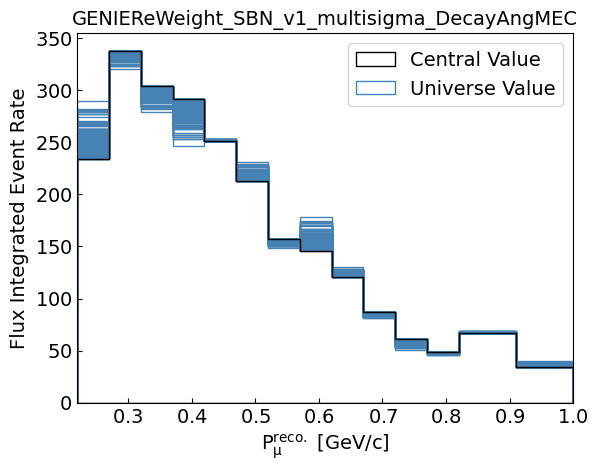

In [93]:
n_univ_genie_morph = 250

cov_type = "event"
GENIEmorph_Frac_Covariance_event = np.zeros((len(var_config.bins)-1, len(var_config.bins)-1))
plot_labels = [var_config.var_labels[1], "Flux Integrated Event Rate"]
syst_name = knob
save_fig_name = "{}/{}-{}-geniemorph_univ_{}_rates".format(save_fig_dir, var_config.var_save_name, syst_name, cov_type)
ret_geniemorph_manyuniv = get_covariance(cov_type, syst_name, n_univ_genie_morph, 
                        nevts_signal_sel_reco, var_signal_sel_truth, var_signal_sel_reco, var_config.bins, 
                        plot_labels, save_fig=save_fig, save_fig_name=save_fig_name)

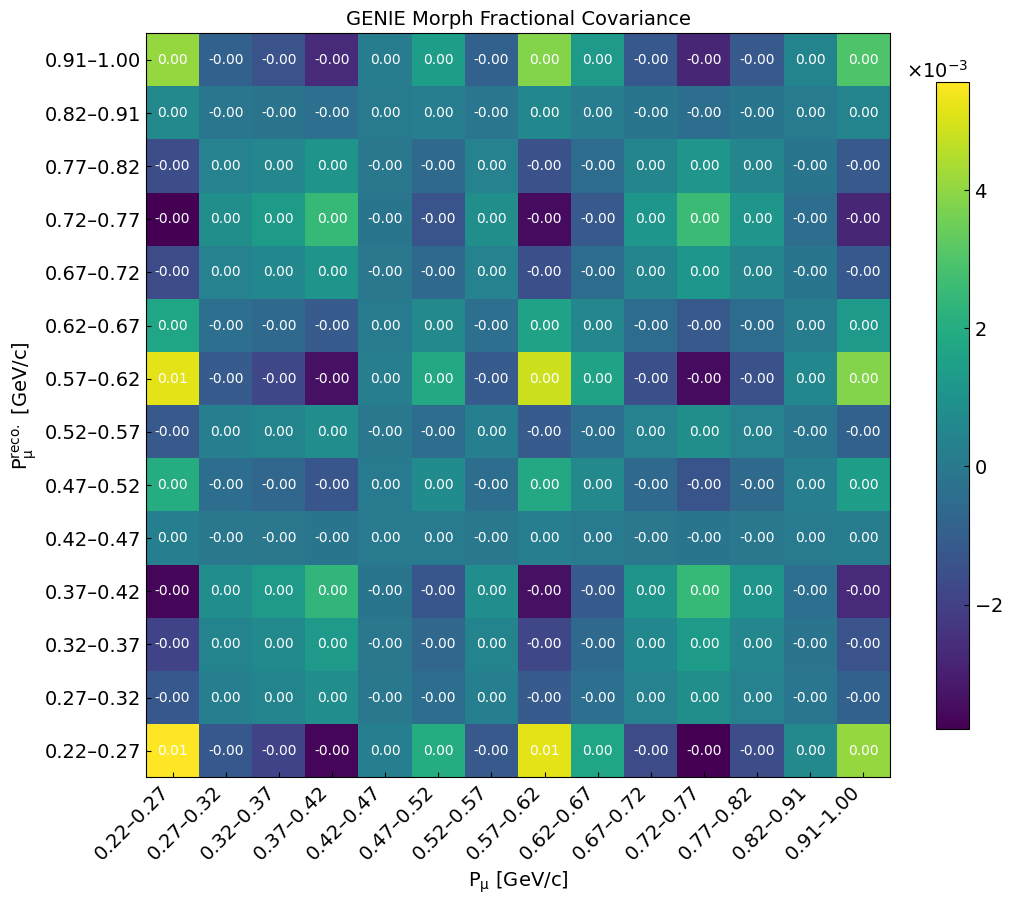

In [96]:
plot_heatmap(ret_geniemorph_manyuniv["Covariance_Frac"], "GENIE Morph Fractional Covariance",
             save_fig=save_fig, save_fig_name=save_fig_name)

In [95]:
ret_geniemorph['Covariance_Frac']/ret_geniemorph_manyuniv['Covariance_Frac']

array([[0.2847481, 0.2847481, 0.2847481, 0.2847481, 0.2847481, 0.2847481,
        0.2847481, 0.2847481, 0.2847481, 0.2847481, 0.2847481, 0.2847481,
        0.2847481, 0.2847481],
       [0.2847481, 0.2847481, 0.2847481, 0.2847481, 0.2847481, 0.2847481,
        0.2847481, 0.2847481, 0.2847481, 0.2847481, 0.2847481, 0.2847481,
        0.2847481, 0.2847481],
       [0.2847481, 0.2847481, 0.2847481, 0.2847481, 0.2847481, 0.2847481,
        0.2847481, 0.2847481, 0.2847481, 0.2847481, 0.2847481, 0.2847481,
        0.2847481, 0.2847481],
       [0.2847481, 0.2847481, 0.2847481, 0.2847481, 0.2847481, 0.2847481,
        0.2847481, 0.2847481, 0.2847481, 0.2847481, 0.2847481, 0.2847481,
        0.2847481, 0.2847481],
       [0.2847481, 0.2847481, 0.2847481, 0.2847481, 0.2847481, 0.2847481,
        0.2847481, 0.2847481, 0.2847481, 0.2847481, 0.2847481, 0.2847481,
        0.2847481, 0.2847481],
       [0.2847481, 0.2847481, 0.2847481, 0.2847481, 0.2847481, 0.2847481,
        0.2847481, 0.2847481, 0

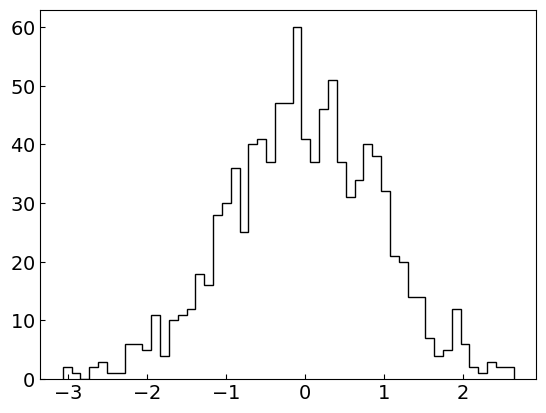

0.5737564544642647

In [83]:
wgts = np.random.normal(0, 1, 1000)
plt.hist(wgts, bins=51, histtype="step", color="black", label="CV")
plt.show()
np.std(wgts)
np.std(np.abs(wgts))

# Profile resource usage

In [6]:
filename = "/exp/sbnd/app/users/munjung/nusyst/jobs/test.root"
filename = "/pnfs/sbn/data_add/sbn_nd/poms_production/mc/MCP2025B_1e20_02/v10_06_00_02/prodgenie_corsika_proton_rockbox_sbnd/CV/caf/73/01/caf-22e837d5-2cdc-43a1-aad4-ed5a1292a5fe.root"
events = uproot.open(filename)

In [7]:
events['recTree'].keys()

['rec',
 'rec/hdr',
 'rec/hdr/hdr.run',
 'rec/hdr/hdr.subrun',
 'rec/hdr/hdr.evt',
 'rec/hdr/hdr.subevt',
 'rec/hdr/hdr.ismc',
 'rec/hdr/hdr.isblind',
 'rec/hdr/hdr.fno',
 'rec/hdr/hdr.ngenevt',
 'rec/hdr/hdr.pot',
 'rec/hdr/hdr.mctype',
 'rec/hdr/hdr.det',
 'rec/hdr/hdr.first_in_subrun',
 'rec/hdr/hdr.first_in_file',
 'rec/hdr/hdr.proc',
 'rec/hdr/hdr.cluster',
 'rec/hdr/hdr.nbnbinfo',
 'rec/hdr/hdr.bnbinfo',
 'rec/hdr/hdr.bnbinfo/hdr.bnbinfo.spill_time_sec',
 'rec/hdr/hdr.bnbinfo/hdr.bnbinfo.spill_time_nsec',
 'rec/hdr/hdr.bnbinfo/hdr.bnbinfo.event',
 'rec/hdr/hdr.bnbinfo/hdr.bnbinfo.TOR860',
 'rec/hdr/hdr.bnbinfo/hdr.bnbinfo.TOR875',
 'rec/hdr/hdr.bnbinfo/hdr.bnbinfo.LM875A',
 'rec/hdr/hdr.bnbinfo/hdr.bnbinfo.LM875B',
 'rec/hdr/hdr.bnbinfo/hdr.bnbinfo.LM875C',
 'rec/hdr/hdr.bnbinfo/hdr.bnbinfo.HP875',
 'rec/hdr/hdr.bnbinfo/hdr.bnbinfo.VP875',
 'rec/hdr/hdr.bnbinfo/hdr.bnbinfo.HPTG1',
 'rec/hdr/hdr.bnbinfo/hdr.bnbinfo.VPTG1',
 'rec/hdr/hdr.bnbinfo/hdr.bnbinfo.HPTG2',
 'rec/hdr/hdr.bn

In [12]:
events["globalTree"]['global/wgts/wgts.name'].arrays(library="np")['wgts.name']

array([array(['GENIEReWeight_SBN_v1_multisigma_ZExpA1CCQE',
              'GENIEReWeight_SBN_v1_multisigma_ZExpA2CCQE',
              'GENIEReWeight_SBN_v1_multisigma_ZExpA3CCQE',
              'GENIEReWeight_SBN_v1_multisigma_ZExpA4CCQE',
              'GENIEReWeight_SBN_v1_multisigma_VecFFCCQEshape',
              'GENIEReWeight_SBN_v1_multisigma_RPA_CCQE',
              'GENIEReWeight_SBN_v1_multisigma_CoulombCCQE',
              'GENIEReWeight_SBN_v1_multisigma_NormCCMEC',
              'GENIEReWeight_SBN_v1_multisigma_NormNCMEC',
              'GENIEReWeight_SBN_v1_multisigma_DecayAngMEC',
              'GENIEReWeight_SBN_v1_multisigma_MaNCEL',
              'GENIEReWeight_SBN_v1_multisigma_EtaNCEL',
              'GENIEReWeight_SBN_v1_multisigma_MaCCRES',
              'GENIEReWeight_SBN_v1_multisigma_MvCCRES',
              'GENIEReWeight_SBN_v1_multisigma_MaNCRES',
              'GENIEReWeight_SBN_v1_multisigma_MvNCRES',
              'GENIEReWeight_SBN_v1_multisigma_NonRESBGvp

In [6]:
# Use line_profiler to profile the function without breaking it up
profiler = line_profiler.LineProfiler()

# Wrap the function to profile
profiled_func = profiler(make_numucc1p0pi_evtdf)
# profiled_func = profiler(make_mcnudf)

tracemalloc.start()
start_time = time.perf_counter()

# Run the profiled function
ret = profiled_func(events)

end_time = time.perf_counter()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f"Time elapsed: {end_time - start_time:.2f} seconds")
print(f"Current memory usage: {current / 10**6:.2f} MB; Peak was {peak / 10**6:.2f} MB")

print("\nLine-by-line timing profile for make_numucc1p0pi_evtdf:")
profiler.print_stats()

# Save binned weights for cov matrices

In [5]:
from variable_configs import VariableConfig
from makedf.geniesyst import regen_systematics_sbnd_multisigma, regen_systematics_sbnd_morph
from tqdm import tqdm
from multiprocessing import Pool

In [6]:
filelist = !tail -n 10 /exp/sbnd/app/users/munjung/misc/filelists/MC/SBND/hadd_log_389.txt
filelist

['/pnfs/sbn/data_add/sbn_nd/poms_production/mc/MCP2025B_1e20_02/v10_06_00_02/prodgenie_corsika_proton_rockbox_sbnd/CV/caf/4e/8a/caf.flat.caf-ab816fda-c9d8-4869-a72d-f1f7b983b052.root',
 '/pnfs/sbn/data_add/sbn_nd/poms_production/mc/MCP2025B_1e20_02/v10_06_00_02/prodgenie_corsika_proton_rockbox_sbnd/CV/caf/9d/5c/caf.flat.caf-1c81166d-dd0d-44ae-ac86-3228819b4df8.root',
 '/pnfs/sbn/data_add/sbn_nd/poms_production/mc/MCP2025B_1e20_02/v10_06_00_02/prodgenie_corsika_proton_rockbox_sbnd/CV/caf/09/09/caf.flat.caf-1869063b-c9f1-4e6a-b366-bacce795b0c6.root',
 '/pnfs/sbn/data_add/sbn_nd/poms_production/mc/MCP2025B_1e20_02/v10_06_00_02/prodgenie_corsika_proton_rockbox_sbnd/CV/caf/d5/e3/caf.flat.caf-361c8e8b-bd76-4926-803b-320cd5eeef62.root',
 '/pnfs/sbn/data_add/sbn_nd/poms_production/mc/MCP2025B_1e20_02/v10_06_00_02/prodgenie_corsika_proton_rockbox_sbnd/CV/caf/48/78/caf.flat.caf-a4913553-3ded-49c7-bac4-78eeadcb572c.root',
 '/pnfs/sbn/data_add/sbn_nd/poms_production/mc/MCP2025B_1e20_02/v10_06_00_0

In [7]:
def make_numucc1p0pi_binned_systs(f):
    if isinstance(f, str):
        events = uproot.open(f)
    else:
        events = f
    try:
        ret = make_numucc1p0pi_evtdf_final_wgts(events, mode="cov")

    except Exception as e:
        print(f"exception: {e}")
        return None

    return ret

In [8]:
filename = filelist[0]
print(filename)
events = uproot.open(filename)
df_mcnu, df_sel = make_numucc1p0pi_binned_systs(events)

/pnfs/sbn/data_add/sbn_nd/poms_production/mc/MCP2025B_1e20_02/v10_06_00_02/prodgenie_corsika_proton_rockbox_sbnd/CV/caf/4e/8a/caf.flat.caf-ab816fda-c9d8-4869-a72d-f1f7b983b052.root
exception: weights should have the same shape as a.


TypeError: cannot unpack non-iterable NoneType object

In [9]:
ret_list = []
with Pool(processes=10) as pool:
    for ridx, ret in enumerate(tqdm(pool.imap_unordered(make_numucc1p0pi_binned_systs, filelist), total=len(filelist), unit="file", delay=5, smoothing=0.2)):
        if ret is not None:
            df_mcnu = df_mcnu + ret[0]
            df_sel = df_sel + ret[1]
            ret_list.append(ret)
        else:
            print(f"Error in make_numucc1p0pi_binned_systs for file {filelist[ridx]}")

df_mcnu
df_sel

/exp/sbnd/app/users/munjung/xsec/wienersvd/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/pandas/core/internals/blocks.py:1429: RuntimeWarning: invalid value encountered in cast
  values[indexer] = casted
/exp/sbnd/app/users/munjung/xsec/wienersvd/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/pandas/core/internals/blocks.py:1429: RuntimeWarning: invalid value encountered in cast
  values[indexer] = casted
/exp/sbnd/app/users/munjung/xsec/wienersvd/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/pandas/core/internals/blocks.py:1429: RuntimeWarning: invalid value encountered in cast
  values[indexer] = casted
/exp/sbnd/app/users/munjung/xsec/wienersvd/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/pandas/core/internals/blocks.py:1429: RuntimeWarning: invalid value encountered in cast
  values[indexer] = casted
/exp/sbnd/app/users/munjung/xsec/wienersvd/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/pandas/core/internal

nuint_categ_1                                                         \
         mu_totp                                                          
              cv GENIE_multisim                                           
                         univ_0    univ_1    univ_2    univ_3    univ_4   
0              0       0.000000  0.000000  0.000000  0.000000  0.000000   
1              1       0.103339  1.305678  1.910495  1.429552  0.435874   
2              1       0.810983  1.045059  1.220180  1.242572  0.713852   
3              0       0.000000  0.000000  0.000000  0.000000  0.000000   
4              0       0.000000  0.000000  0.000000  0.000000  0.000000   
5              1       0.132607  1.361421  1.747805  0.951430  0.752743   
6              0       0.000000  0.000000  0.000000  0.000000  0.000000   
7              0       0.000000  0.000000  0.000000  0.000000  0.000000   
8              0       0.000000  0.000000  0.000000  0.000000  0.000000   
9              0       0.000000  0.000000  0.000000  0.000000  0.000000   
10             0       0.000000  0.000000  0.000000  0.000000  0.000000   
11             0       0.000000  0.000000  0.000000  0.000000  0.000000   
12             0       0.000000  0.000000  0.000000  0.000000  0.000000   
13             0       0.000000  0.000000  0.000000  0.000000  0.000000   

                                            ... nuint_categ_-1           \
                                            ...     mc_del_phi            
                                            ...           Flux            
      univ_5    univ_6    univ_7    univ_8  ...       univ_490 univ_491   
0   0.000000  0.000000  0.000000  0.000000  ...            0.0      0.0   
1   0.624278  0.663169  1.150506  0.643099  ...            0.0      0.0   
2   0.678008  1.140203  1.103700  1.018245  ...            0.0      0.0   
3   0.000000  0.000000  0.000000  0.000000  ...            0.0      0.0   
4   0.000000  0.000000  0.000000  0.000000  ...            0.0      0.0   
5   0.905352  0.568370  1.134167  0.708597  ...            0.0      0.0   
6   0.000000  0.000000  0.000000  0.000000  ...            0.0      0.0   
7   0.000000  0.000000  0.000000  0.000000  ...            0.0      0.0   
8   0.000000  0.000000  0.000000  0.000000  ...            0.0      0.0   
9   0.000000  0.000000  0.000000  0.000000  ...            0.0      0.0   
10  0.000000  0.000000  0.000000  0.000000  ...            0.0      0.0   
11  0.000000  0.000000  0.000000  0.000000  ...            0.0      0.0   
12  0.000000  0.000000  0.000000  0.000000  ...            0.0      0.0   
13  0.000000  0.000000  0.000000  0.000000  ...            0.0      0.0   

                                                                            
                                                                            
                                                                            
   univ_492 univ_493 univ_494 univ_495 univ_496 univ_497 univ_498 univ_499  
0       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
1       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
2       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
3       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
4       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
5       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
6       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
7       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
8       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
9       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
10      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
11      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
12      0.0      0.0      0.0      0.0      0.0      0.0      0.0    

In [ ]:
df_mcnu

nuint_categ_1                                                         \
         mu_totp                                                          
              cv GENIE_multisim                                           
                         univ_0    univ_1    univ_2    univ_3    univ_4   
0              0       0.000000  0.000000  0.000000  0.000000  0.000000   
1              1       0.103339  1.305678  1.910495  1.429552  0.435874   
2              4       4.411919  3.135367  3.262414  5.333888  3.766692   
3              2       1.633723  2.080932  2.421089  2.506663  1.460427   
4              2       1.714678  2.015856  2.322739  2.405984  1.618321   
5              3       2.394166  2.911180  3.370601  3.563163  2.868605   
6              3       2.914346  2.530420  2.943627  4.075222  2.517026   
7              2       0.922551  2.355808  2.967849  2.158328  1.431521   
8              0       0.000000  0.000000  0.000000  0.000000  0.000000   
9              1       0.933607  1.112552  1.216454  0.942935  0.893297   
10             1       0.903782  0.991138  1.123347  1.128447  0.886039   
11             2       1.117237  2.354249  2.737615  1.892788  1.787131   
12             0       0.000000  0.000000  0.000000  0.000000  0.000000   
13             0       0.000000  0.000000  0.000000  0.000000  0.000000   

                                            ... nuint_categ_-1           \
                                            ...     mc_del_phi            
                                            ...           Flux            
      univ_5    univ_6    univ_7    univ_8  ...       univ_490 univ_491   
0   0.000000  0.000000  0.000000  0.000000  ...            0.0      0.0   
1   0.624278  0.663169  1.150506  0.643099  ...            0.0      0.0   
2   3.036505  4.418061  4.200951  3.643591  ...            0.0      0.0   
3   1.395704  2.266571  2.220546  2.035115  ...            0.0      0.0   
4   1.558939  2.198147  2.246197  2.032886  ...            0.0      0.0   
5   2.388596  2.662094  3.269679  2.425885  ...            0.0      0.0   
6   2.751711  3.553312  3.526538  3.043696  ...            0.0      0.0   
7   2.181709  1.847740  2.433391  1.980016  ...            0.0      0.0   
8   0.000000  0.000000  0.000000  0.000000  ...            0.0      0.0   
9   0.746282  1.067459  1.061452  1.101103  ...            0.0      0.0   
10  0.853861  1.066078  1.124017  1.023713  ...            0.0      0.0   
11  1.896125  1.576272  2.178133  1.740269  ...            0.0      0.0   
12  0.000000  0.000000  0.000000  0.000000  ...            0.0      0.0   
13  0.000000  0.000000  0.000000  0.000000  ...            0.0      0.0   

                                                                            
                                                                            
                                                                            
   univ_492 univ_493 univ_494 univ_495 univ_496 univ_497 univ_498 univ_499  
0       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
1       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
2       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
3       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
4       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
5       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
6       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
7       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
8       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
9       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
10      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
11      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
12      0.0      0.0      0.0      0.0      0.0      0.0      0.0    

In [11]:
var_config = VariableConfig.muon_momentum()

In [12]:
ret_list[0][0]

nuint_categ_1                                                         \
         mu_totp                                                          
              cv GENIE_multisim                                           
                         univ_0    univ_1    univ_2    univ_3    univ_4   
0              0       0.000000  0.000000  0.000000  0.000000  0.000000   
1              0       0.000000  0.000000  0.000000  0.000000  0.000000   
2              0       0.000000  0.000000  0.000000  0.000000  0.000000   
3              0       0.000000  0.000000  0.000000  0.000000  0.000000   
4              0       0.000000  0.000000  0.000000  0.000000  0.000000   
5              0       0.000000  0.000000  0.000000  0.000000  0.000000   
6              1       1.391533  0.587160  0.532478  1.286279  1.227777   
7              0       0.000000  0.000000  0.000000  0.000000  0.000000   
8              0       0.000000  0.000000  0.000000  0.000000  0.000000   
9              0       0.000000  0.000000  0.000000  0.000000  0.000000   
10             1       0.903782  0.991138  1.123347  1.128447  0.886039   
11             0       0.000000  0.000000  0.000000  0.000000  0.000000   
12             0       0.000000  0.000000  0.000000  0.000000  0.000000   
13             0       0.000000  0.000000  0.000000  0.000000  0.000000   

                                            ... nuint_categ_-1           \
                                            ...     mc_del_phi            
                                            ...           Flux            
      univ_5    univ_6    univ_7    univ_8  ...       univ_490 univ_491   
0   0.000000  0.000000  0.000000  0.000000  ...            0.0      0.0   
1   0.000000  0.000000  0.000000  0.000000  ...            0.0      0.0   
2   0.000000  0.000000  0.000000  0.000000  ...            0.0      0.0   
3   0.000000  0.000000  0.000000  0.000000  ...            0.0      0.0   
4   0.000000  0.000000  0.000000  0.000000  ...            0.0      0.0   
5   0.000000  0.000000  0.000000  0.000000  ...            0.0      0.0   
6   0.803792  1.076580  1.048954  0.841646  ...            0.0      0.0   
7   0.000000  0.000000  0.000000  0.000000  ...            0.0      0.0   
8   0.000000  0.000000  0.000000  0.000000  ...            0.0      0.0   
9   0.000000  0.000000  0.000000  0.000000  ...            0.0      0.0   
10  0.853861  1.066078  1.124017  1.023713  ...            0.0      0.0   
11  0.000000  0.000000  0.000000  0.000000  ...            0.0      0.0   
12  0.000000  0.000000  0.000000  0.000000  ...            0.0      0.0   
13  0.000000  0.000000  0.000000  0.000000  ...            0.0      0.0   

                                                                            
                                                                            
                                                                            
   univ_492 univ_493 univ_494 univ_495 univ_496 univ_497 univ_498 univ_499  
0       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
1       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
2       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
3       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
4       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
5       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
6       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
7       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
8       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
9       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
10      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
11      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
12      0.0      0.0      0.0      0.0      0.0      0.0      0.0    

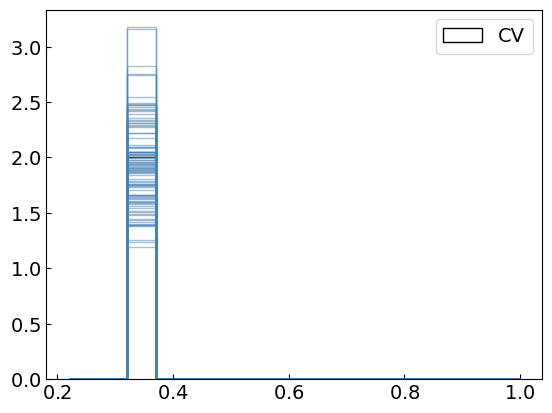

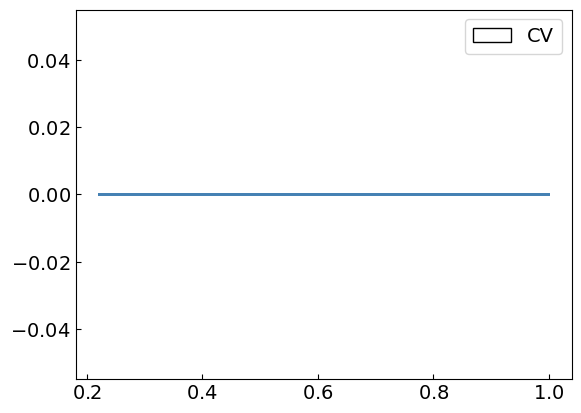

In [13]:
fidx = 4
plt.hist(var_config.bin_centers, bins=var_config.bins, weights=ret_list[fidx][0]["nuint_categ_1"]["mu_totp"]["cv"], histtype='step', color="k", label="CV")
syst_name = "GENIE_multisim"
for i in range(100):
    plt.hist(var_config.bin_centers, bins=var_config.bins, weights=ret_list[fidx][0]["nuint_categ_1"]["mu_totp"][syst_name]["univ_{}".format(i)], histtype='step', color="steelblue", alpha=0.5)
plt.legend()
plt.show();

plt.hist(var_config.bin_centers, bins=var_config.bins, weights=ret_list[fidx][1]["nuint_categ_1"]["mu_totp"]["cv"], histtype='step', color="k", label="CV")
syst_name = "GENIE_multisim"
for i in range(100):
    plt.hist(var_config.bin_centers, bins=var_config.bins, weights=ret_list[fidx][1]["nuint_categ_1"]["mu_totp"][syst_name]["univ_{}".format(i)], histtype='step', color="steelblue", alpha=0.5)
plt.legend()
plt.show();

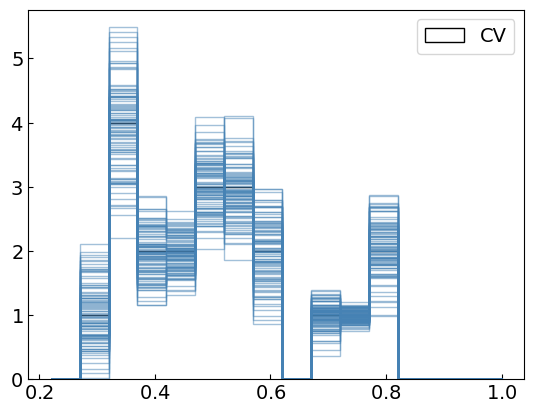

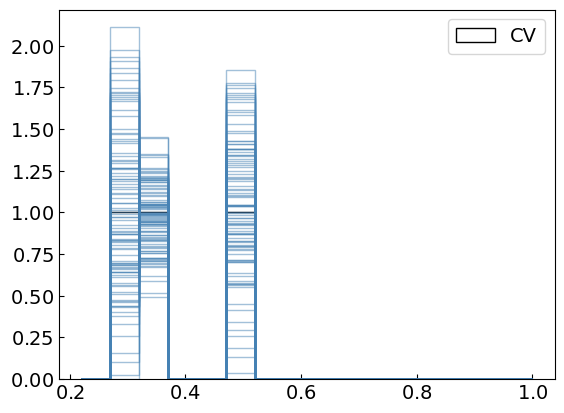

In [14]:
plt.hist(var_config.bin_centers, bins=var_config.bins, weights=df_mcnu["nuint_categ_1"]["mu_totp"]["cv"], histtype='step', color="k", label="CV")
syst_name = "GENIE_multisim"
for i in range(100):
    plt.hist(var_config.bin_centers, bins=var_config.bins, weights=df_mcnu["nuint_categ_1"]["mu_totp"][syst_name]["univ_{}".format(i)], histtype='step', color="steelblue", alpha=0.5)
plt.legend()
plt.show();

plt.hist(var_config.bin_centers, bins=var_config.bins, weights=df_sel["nuint_categ_1"]["mu_totp"]["cv"], histtype='step', color="k", label="CV")
syst_name = "GENIE_multisim"
for i in range(100):
    plt.hist(var_config.bin_centers, bins=var_config.bins, weights=df_sel["nuint_categ_1"]["mu_totp"][syst_name]["univ_{}".format(i)], histtype='step', color="steelblue", alpha=0.5)
plt.legend()
plt.show();

In [6]:
# with pd.HDFStore("df_all.h5") as hdf_pd:
#     hdf_pd.put(key="df_all", value=mcdf, format="fixed")

# Read a hist file

In [13]:
# df = pd.read_hdf("df_all.h5", key="df_all")

In [7]:
df_all = pd.read_hdf("/exp/sbnd/data/users/munjung/xsec/2025B/syst_df_1.h5", key="df_mcnu")
for i in [2,3,4,5]:
    df = pd.read_hdf("/exp/sbnd/data/users/munjung/xsec/2025B/syst_df_{}.h5".format(i), key="df_mcnu")
    df_all = df_all + df

df_all.to_hdf("/exp/sbnd/data/users/munjung/xsec/2025B/syst_df.h5", key="df_mcnu")

# df_all = pd.read_hdf("/exp/sbnd/data/users/munjung/xsec/2025B/syst_sel_df_1.h5", key="df_mcnu")
# for i in [2,3,4,5]:
#     df = pd.read_hdf("/exp/sbnd/data/users/munjung/xsec/2025B/syst_sel_df_{}.h5".format(i), key="df_mcnu")
#     df_all = df_all + df

# df_all.to_hdf("/exp/sbnd/data/users/munjung/xsec/2025B/syst_sel_df.h5", key="df_mcnu")

In [14]:
# df.pot

/tmp/ipykernel_81719/330432576.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


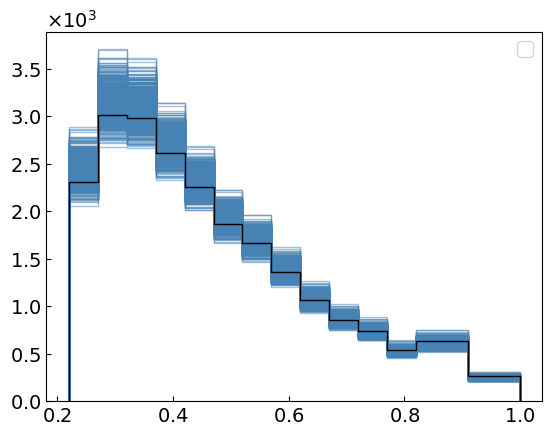

/tmp/ipykernel_81719/330432576.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


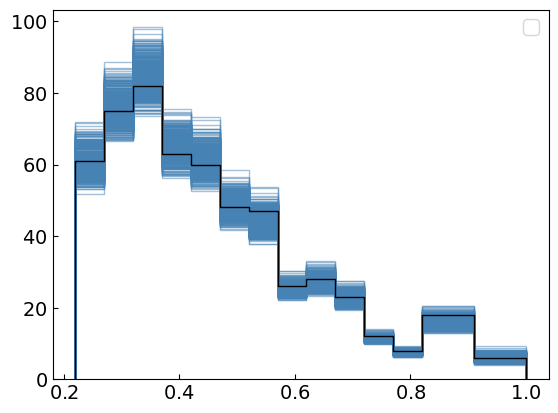

/tmp/ipykernel_81719/330432576.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


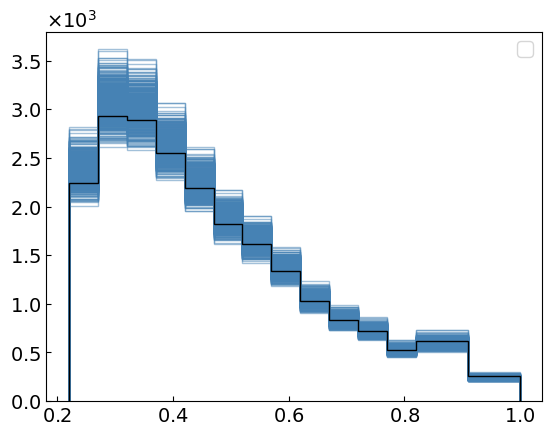

In [10]:
var_config = VariableConfig.muon_momentum()
# syst_name = "GENIE_multisim"
syst_name = "Flux"
for i in range(500):
    plt.hist(var_config.bin_centers, bins=var_config.bins, weights=df["nuint_categ_1"]["mu_totp"][syst_name]["univ_{}".format(i)], histtype='step', color="steelblue", alpha=0.5)
plt.legend()
plt.hist(var_config.bin_centers, bins=var_config.bins, weights=df["nuint_categ_1"]["mu_totp"]["cv"], histtype='step', color="k", label="CV")
plt.show();

syst_name = "Flux"
for i in range(500):
    plt.hist(var_config.bin_centers, bins=var_config.bins, weights=df["nuint_categ_2"]["mu_totp"][syst_name]["univ_{}".format(i)], histtype='step', color="steelblue", alpha=0.5)
plt.legend()
plt.hist(var_config.bin_centers, bins=var_config.bins, weights=df["nuint_categ_2"]["mu_totp"]["cv"], histtype='step', color="k", label="CV")
plt.show();


syst_name = "Flux"
for i in range(500):
    weights =  df["nuint_categ_1"]["mu_totp"][syst_name]["univ_{}".format(i)] - df["nuint_categ_2"]["mu_totp"][syst_name]["univ_{}".format(i)]
    plt.hist(var_config.bin_centers, bins=var_config.bins, weights=weights, histtype='step', color="steelblue", alpha=0.5)
plt.legend()
weights =  df["nuint_categ_1"]["mu_totp"]["cv"] - df["nuint_categ_2"]["mu_totp"]["cv"]
plt.hist(var_config.bin_centers, bins=var_config.bins, weights=weights, histtype='step', color="k", label="CV")
plt.show();

In [18]:
np.array(df["nuint_categ_1"]["mu_totp"]["GENIE_multisim"]["univ_0"])*100

array([17538.36204779, 18103.57924741, 20320.96918965, 19652.38882138,
       18372.92451533, 16344.88938116, 15545.69539653, 13495.89973166,
       11198.64913267, 10981.97262393,  9984.7408216 ,  7260.28846775,
       14286.19626598, 12102.16475155])

In [ ]:
filelist = "/exp/sbnd/app/users/munjung/misc/filelists/MC/SBND/MCP2025B_full_test.list"